In [93]:
import polars as pl
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from math import floor
from datetime import datetime

In [94]:
INDEX_AXLE_INFORMATION = 8
INDEX_GROSS_WEIGHT = 9
INDEX_START_AXLE_WEIGHT = 10
LIMIT_ESAL_VALUE = 10
INDEX_DATE = 1

In [95]:
def calculate_b_factor_and_esal(filepath: str) -> float:
    df = pl.read_csv(filepath, has_header=False, truncate_ragged_lines=True, ignore_errors=True, separator=';', decimal_comma=True)
    df = df.filter(pl.nth(INDEX_GROSS_WEIGHT) > 3.5)

    earliest_date = df.select(pl.nth(INDEX_DATE)).min().item(0, 0)[0:10]
    latest_date = df.select(pl.nth(INDEX_DATE)).max().item(0, 0)[0:10]
    esal_values_individual_vehicles = calculate_esal_values(df)
    n = len(df)
    b_factor = np.sum(esal_values_individual_vehicles) / n

    return b_factor, esal_values_individual_vehicles, earliest_date, latest_date

def calculate_esal_values(df: pl.DataFrame) -> float:
    esal_values_individual_vehicles = np.array([])
    
    for row in df.iter_rows(named=False):
        axle_weights, k_values = determine_axle_weights_and_corresponding_k_values(row)
        esal_values_individual_vehicles = np.append(esal_values_individual_vehicles, np.sum((axle_weights / 10)**4 * k_values))

    return esal_values_individual_vehicles

def determine_axle_weights_and_corresponding_k_values(row: tuple) -> tuple:
    axle_weights = np.array([])
    k_values = np.array([])
    
    axle_setup_code = row[INDEX_AXLE_INFORMATION]
    axle_groups = [int(axle) for axle in str(axle_setup_code)]
    used_axle_groups = 0

    for axle_group in axle_groups:
        local_axle_weights = row[INDEX_START_AXLE_WEIGHT + used_axle_groups : INDEX_START_AXLE_WEIGHT + used_axle_groups + axle_group]
        used_axle_groups += axle_group
        axle_weights = np.append(axle_weights, patch_weight_data(local_axle_weights))
        k_values = np.append(k_values, k_value(axle_group))
        
    return axle_weights, k_values

def k_value(axles: int) -> float:
    if axles == 1:
        return 1
    else:
        return (10 / (6 + 6 * axles))**4

def patch_weight_data(weights: tuple) -> tuple:
    return sum(float(weight.replace(',', '.')) if type(weight) == str else weight for weight in weights)

def extract_location(filepath):
    if 'Sorbryn' in filepath:
        return 'Sørbryn'
    if 'Tangensvingen' in filepath:
        return 'Tangensvingen'
    if 'Fredrikstad' in filepath:
        return 'Fredrikstadbrua'


In [96]:
datasets = (
    '../WIM-data/202210 okt22 14-20/Sorbryn_2022_newer_nswd_v0,9.csv',
    # '../WIM-data/202210 okt22 14-20/Sorbryn_2022_newer_nswd_v10022023.csv',
    '../WIM-data/202210 okt22 14-20/Tangensvingen_2022_newer_nswd.csv',
    # '../WIM-data/202210 okt22 14-20/Tangensvingen_2022_newer_nswd_v0,9.csv',
    # '../WIM-data/202210 okt22 14-20/Tangensvingen_2022_newer_nswd_v27122022.csv',
    '../WIM-data/202302 feb23 21-27/Sorbryn_feb2023_newer_nswd.csv',
    '../WIM-data/202302 feb23 21-27/Tangensvingen_feb2023_newer_nswd.csv',
    '../WIM-data/202304 april23 17-23/Sorbryn_april2023_newer_nswd.csv',
    '../WIM-data/202304 april23 17-23/Tangensvingen_April2023_newer_nswd.csv',
    '../WIM-data/202310 okt23 16-22/Sorbryn_oktober2023_newer_nswd.csv',
    '../WIM-data/202310 okt23 16-22/Tangensvingen_Oktober2023_newer_nswd.csv',
    '../WIM-data/202402 feb24 26feb-3mars/Sorbryn_february2024_newer_nswd.csv',
    '../WIM-data/202402 feb24 26feb-3mars/Tangensvingen_Februari2024_newer_nswd.csv',
    '../WIM-data/202404 april24 18-24/Sorbryn_april2024_newer_nswd.csv',
    '../WIM-data/202404 april24 18-24/Tangensvingen_April2024_newer_nswd.csv',
    '../WIM-data/Fredrikstadbrua/Fredrikstad_february2024_newer_nswd.csv'
)

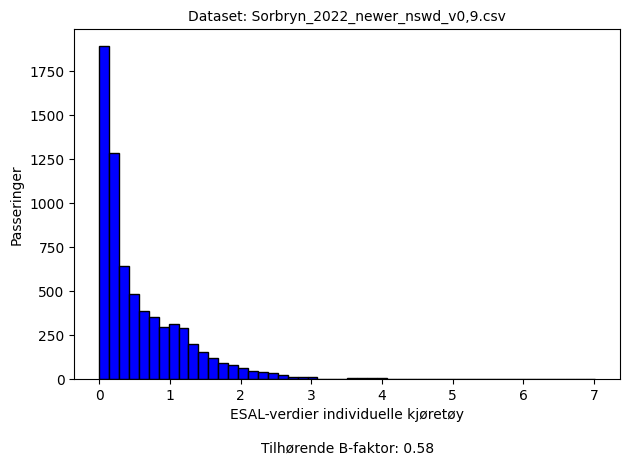

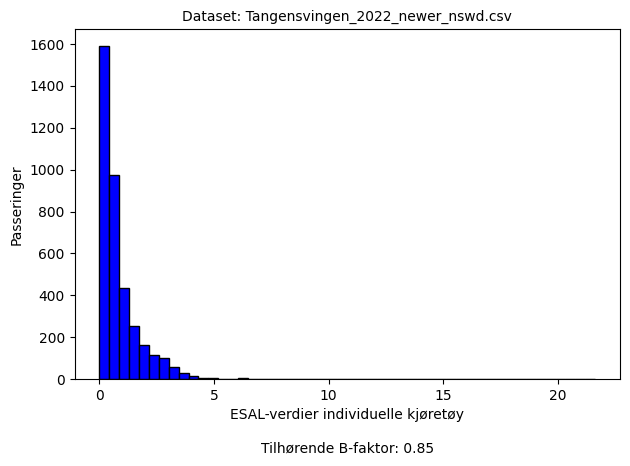

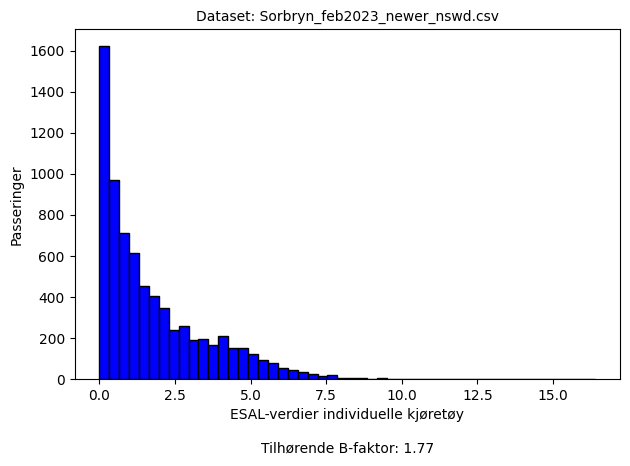

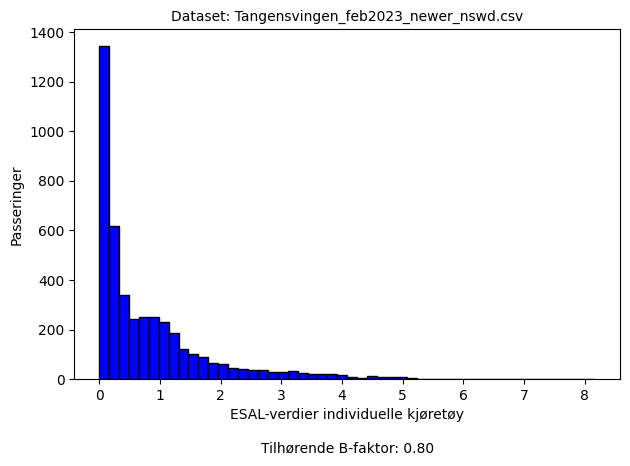

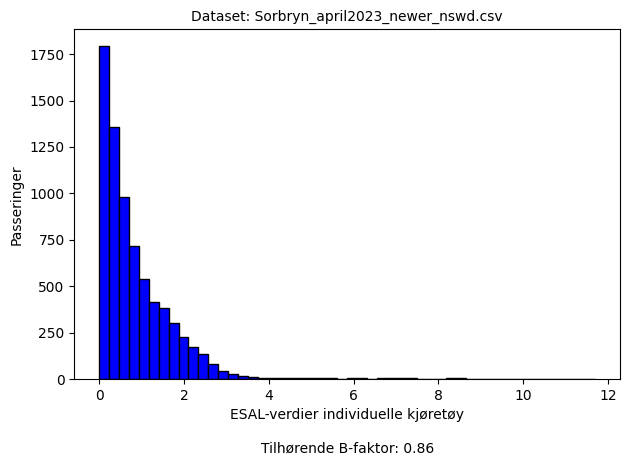

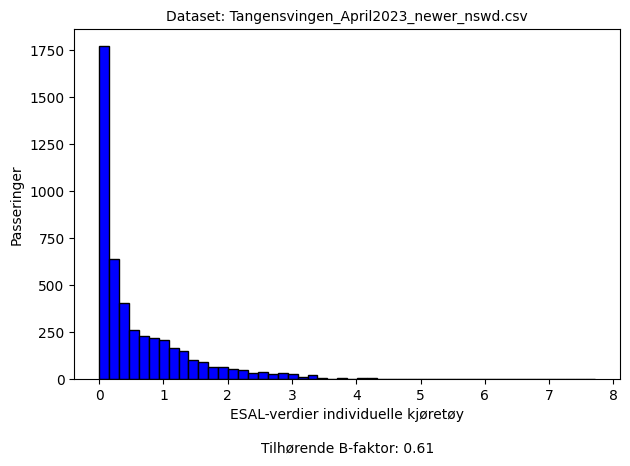

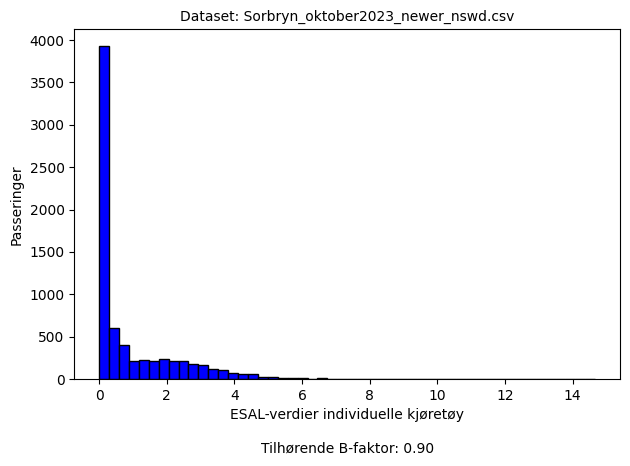

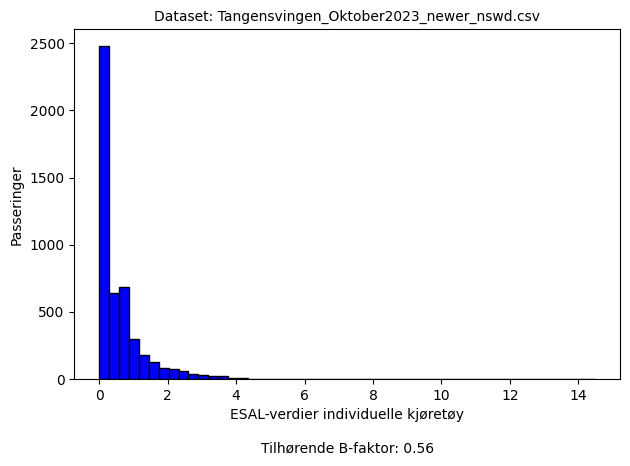

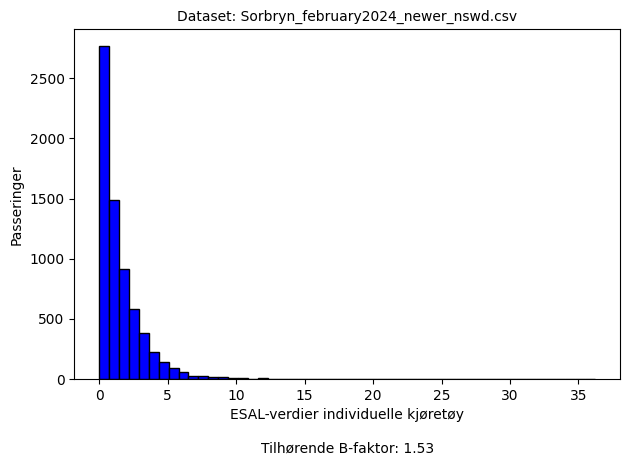

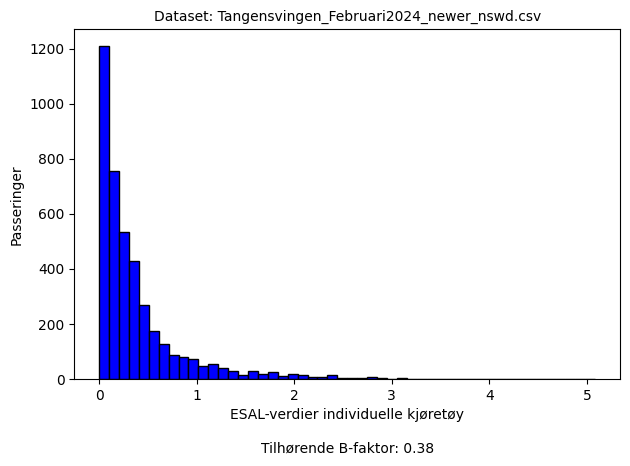

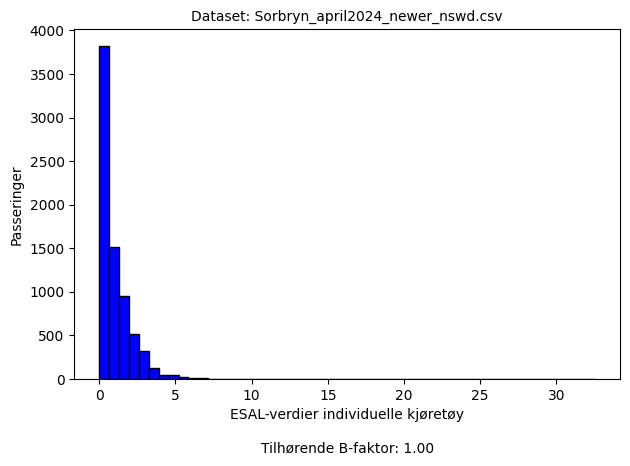

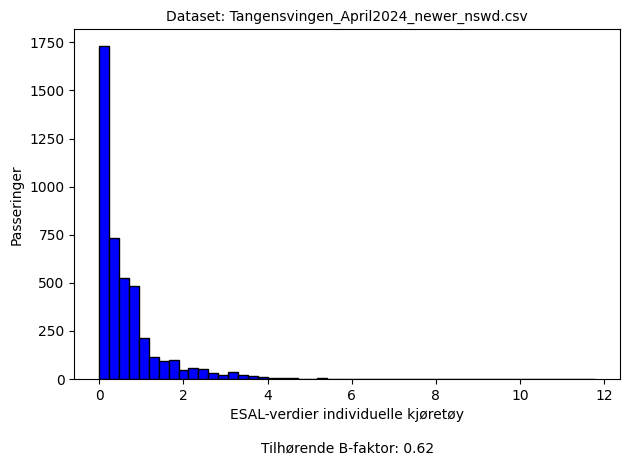

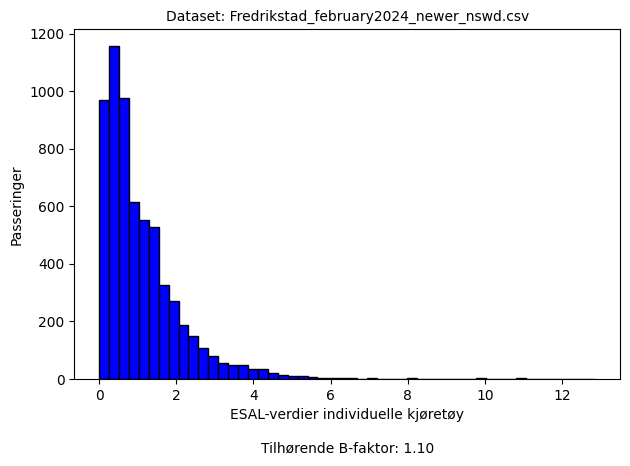

shape: (13, 54)
┌────────────────┬────────────┬────────────┬──────────┬───┬─────────┬─────────┬─────────┬──────────┐
│ location       ┆ startdate  ┆ enddate    ┆ B-faktor ┆ … ┆ 9.2-9.4 ┆ 9.4-9.6 ┆ 9.6-9.8 ┆ 9.8-10.0 │
│ ---            ┆ ---        ┆ ---        ┆ ---      ┆   ┆ ---     ┆ ---     ┆ ---     ┆ ---      │
│ str            ┆ str        ┆ str        ┆ f64      ┆   ┆ i64     ┆ i64     ┆ i64     ┆ i64      │
╞════════════════╪════════════╪════════════╪══════════╪═══╪═════════╪═════════╪═════════╪══════════╡
│ Sørbryn        ┆ 2022-10-14 ┆ 2022-10-20 ┆ 0.577689 ┆ … ┆ 0       ┆ 0       ┆ 0       ┆ 0        │
│ Tangensvingen  ┆ 2022-10-14 ┆ 2022-10-20 ┆ 0.849872 ┆ … ┆ 0       ┆ 0       ┆ 1       ┆ 0        │
│ Sørbryn        ┆ 2023-02-21 ┆ 2023-02-27 ┆ 1.771894 ┆ … ┆ 3       ┆ 2       ┆ 1       ┆ 0        │
│ Tangensvingen  ┆ 2023-02-21 ┆ 2023-02-27 ┆ 0.800377 ┆ … ┆ 0       ┆ 0       ┆ 0       ┆ 0        │
│ Sørbryn        ┆ 2023-04-17 ┆ 2023-04-23 ┆ 0.85787  ┆ … ┆ 0       ┆ 1    

In [97]:
intervals = np.linspace(0, 10, 51)
interval_labels = [f'{intervals[i]:.1f}-{intervals[i+1]:.1f}' for i in range(len(intervals)-1)]
cols = ['location', 'startdate', 'enddate', 'B-faktor'] + interval_labels
rows = []

for i, dataset in enumerate(datasets):
    try:
        location = extract_location(dataset)
        name_dataset = dataset.split('/')[-1] 
        b_factor, esal_values, startdate, enddate = calculate_b_factor_and_esal(dataset)

        plt.hist(esal_values, bins=50, color='blue', edgecolor='black')
        plt.xlabel('ESAL-verdier individuelle kjøretøy')
        plt.ylabel('Passeringer')
        plt.title(f'Dataset: {name_dataset}', fontsize=10)
        plt.text(0.5, -0.2, f'Tilhørende B-faktor: {b_factor:.2f}', ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
        plt.tight_layout()
        plt.show()

        bins = [0] * 50
        for esal in esal_values:
            if esal >= LIMIT_ESAL_VALUE:
                continue
            bins[floor(esal / 10 * 49)] += 1
        rows.append([location, startdate, enddate, b_factor] + bins)
    except:
        print(dataset)

df = pl.DataFrame(schema=cols, data=rows)
df.write_csv('../resultater/b-faktor_bwim.csv')